In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import mean_squared_error



In [ ]:
class DecisionTreeLeaf:

    def __init__(self, value):
        self.value = value

    # This method computes the prediction for this leaf node. This will just return a constant value.
    def predict(self, x):
        return self.value

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_id = str(node_counter)
        val_str = f'{self.value:.4g}' if isinstance(self.value, float) else str(self.value)
        graph.node(node_id, val_str, style='filled')
        return node_counter+1, node_id
        
    def __eq__(self, other):
        if isinstance(other, DecisionTreeLeaf):
            return self.value == other.value
        else:
            return False

class DecisionTreeBranch:

    def __init__(self, feature, threshold, low_subtree, high_subtree):
        self.feature = feature
        self.threshold = threshold
        self.low_subtree = low_subtree
        self.high_subtree = high_subtree

    # For a branch node, we compute the prediction by first considering the feature, and then 
    # calling the upper or lower subtree, depending on whether the feature is or isn't greater
    # than the threshold.
    def predict(self, x):
        if x[self.feature] <= self.threshold:
            return self.low_subtree.predict(x)
        else:
            return self.high_subtree.predict(x)

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_counter, low_id = self.low_subtree.draw_tree(graph, node_counter, names)
        node_counter, high_id = self.high_subtree.draw_tree(graph, node_counter, names)
        node_id = str(node_counter)
        fname = f'F{self.feature}' if names is None else names[self.feature]
        lbl = f'{fname} > {self.threshold:.4g}?'
        graph.node(node_id, lbl, shape='box', fillcolor='yellow', style='filled, rounded')
        graph.edge(node_id, low_id, 'False')
        graph.edge(node_id, high_id, 'True')
        return node_counter+1, node_id


from graphviz import Digraph
from sklearn.base import BaseEstimator, ClassifierMixin
from abc import ABC, abstractmethod

class DecisionTree(ABC, BaseEstimator):

    def __init__(self, max_depth):
        super().__init__()
        self.max_depth = max_depth
        
    # As usual in scikit-learn, the training method is called *fit*. We first process the dataset so that
    # we're sure that it's represented as a NumPy matrix. Then we call the recursive tree-building method
    # called make_tree (see below).
    def fit(self, X, Y):
        if isinstance(X, pd.DataFrame):
            self.names = X.columns
            X = X.to_numpy()
        elif isinstance(X, list):
            self.names = None
            X = np.array(X)
        else:
            self.names = None
        Y = np.array(Y)        
        self.root = self.make_tree(X, Y, self.max_depth)
        
    def draw_tree(self):
        graph = Digraph()
        self.root.draw_tree(graph, 0, self.names)
        return graph
    
    # By scikit-learn convention, the method *predict* computes the classification or regression output
    # for a set of instances.
    # To implement it, we call a separate method that carries out the prediction for one instance.
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return [self.predict_one(x) for x in X]

    # Predicting the output for one instance.
    def predict_one(self, x):
        return self.root.predict(x)        

    # This is the recursive training 
    def make_tree(self, X, Y, max_depth):

        # We start by computing the default value that will be used if we'll return a leaf node.
        # For classifiers, this will be the most common value in Y.
        default_value = self.get_default_value(Y)

        # First the two base cases in the recursion: is the training set completely
        # homogeneous, or have we reached the maximum depth? Then we need to return a leaf.

        # If we have reached the maximum depth, return a leaf with the majority value.
        if max_depth == 0:
            return DecisionTreeLeaf(default_value)

        # If all the instances in the remaining training set have the same output value,
        # return a leaf with this value.
        if self.is_homogeneous(Y):
            return DecisionTreeLeaf(default_value)

        # Select the "most useful" feature and split threshold. To rank the "usefulness" of features,
        # we use one of the classification or regression criteria.
        # For each feature, we call best_split (defined in a subclass). We then maximize over the features.
        n_features = X.shape[1]
        _, best_feature, best_threshold = max(self.best_split(X, Y, feature) for feature in range(n_features))
        
        if best_feature is None:
            return DecisionTreeLeaf(default_value)

        # Split the training set into subgroups, based on whether the selected feature is greater than
        # the threshold or not
        X_low, X_high, Y_low, Y_high = self.split_by_feature(X, Y, best_feature, best_threshold)

        # Build the subtrees using a recursive call. Each subtree is associated
        # with a value of the feature.
        low_subtree = self.make_tree(X_low, Y_low, max_depth-1)
        high_subtree = self.make_tree(X_high, Y_high, max_depth-1)

        if low_subtree == high_subtree:
            return low_subtree

        # Return a decision tree branch containing the result.
        return DecisionTreeBranch(best_feature, best_threshold, low_subtree, high_subtree)
    
    # Utility method that splits the data into the "upper" and "lower" part, based on a feature
    # and a threshold.
    def split_by_feature(self, X, Y, feature, threshold):
        low = X[:,feature] <= threshold
        high = ~low
        return X[low], X[high], Y[low], Y[high]
    
    # The following three methods need to be implemented by the classification and regression subclasses.
    
    @abstractmethod
    def get_default_value(self, Y):
        pass

    @abstractmethod
    def is_homogeneous(self, Y):
        pass

    @abstractmethod
    def best_split(self, X, Y, feature):
        pass

from collections import Counter

class TreeClassifier(DecisionTree, ClassifierMixin):

    def __init__(self, max_depth=10, criterion='maj_sum'):
        super().__init__(max_depth)
        self.criterion = criterion
        
    def fit(self, X, Y):
        # For decision tree classifiers, there are some different ways to measure
        # the homogeneity of subsets.
        if self.criterion == 'maj_sum':
            self.criterion_function = majority_sum_scorer
        elif self.criterion == 'info_gain':
            self.criterion_function = info_gain_scorer
        elif self.criterion == 'gini':
            self.criterion_function = gini_scorer
        else:
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most common value.
    def get_default_value(self, Y):
        self.class_distribution = Counter(Y)
        return self.class_distribution.most_common(1)[0][0]
    
    # Checks whether a set of output values is homogeneous. In the classification case, 
    # this means that all output values are identical.
    # We assume that we called get_default_value just before, so that we can access
    # the class_distribution attribute. If the class distribution contains just one item,
    # this means that the set is homogeneous.
    def is_homogeneous(self, Y):
        return len(self.class_distribution) == 1
        
    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])        
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)

        # The frequency tables corresponding to the parts *before and including*
        # and *after* the current element.
        low_distr = Counter()
        high_distr = Counter(Y)

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]
            
            # Update the frequency tables.
            low_distr[y_i] += 1
            high_distr[y_i] -= 1

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            #x_next = XY[i+1][0]
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position.
            score = self.criterion_function(i+1, low_distr, n-i-1, high_distr)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + X_sorted[max_i+1])
        return max_score, feature, split_point

def majority_sum_scorer(n_low, low_distr, n_high, high_distr):
    maj_sum_low = low_distr.most_common(1)[0][1]
    maj_sum_high = high_distr.most_common(1)[0][1]
    return maj_sum_low + maj_sum_high
    
def entropy(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return -sum(p*np.log2(p) if p > 0 else 0 for p in ps)

def info_gain_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*entropy(low_distr)+n_high*entropy(high_distr))/(n_low+n_high)

def gini_impurity(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return 1-sum(p**2 for p in ps)
    
def gini_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*gini_impurity(low_distr)+n_high*gini_impurity(high_distr))/(n_low+n_high)

## Step 1: Implementing the regression model

In [ ]:
from collections import Counter
from sklearn.base import RegressorMixin

class TreeRegressor(DecisionTree, RegressorMixin):

    def __init__(self, max_depth=10, criterion='var_red', threshold=0.1):
        super().__init__(max_depth)
        self.criterion = criterion
        self.threshold = threshold
        
    def fit(self, X, Y):
        #The only implemented way of calculating homogeneity is with the variance_reduction formula
        if self.criterion == 'var_red':
            self.criterion_function = variance_calc
        else:
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the mean value
    def get_default_value(self, Y):
        self.class_distribution = Y
        return np.mean(self.class_distribution)
        
    #Check whether a set of output values i homogeneous. In the regression case,
    #this means that the variance of all output values are below a certain threshold.
    #The threshold is specified when creating a TreeRegressor, default value 0.1.
    def is_homogeneous(self, Y):
        return np.var(self.class_distribution) <= self.threshold

    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # We'll keep track of the sum of lower and higher subset respectively, as well as its squared sums.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])        
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)
        varY = np.var(Y)
        
        # Keeps track of sum and squared sum for the high and low partition
        high_sum = sum(Y_sorted)
        low_sum = 0
        
        # Keeps track of the squared sums for the high and low partition
        Y_squared = np.square(Y_sorted)
        high_sq_sum = sum(Y_squared)
        low_sq_sum = 0

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i] 

            # Updates sums and squared sums of high and low partition when element i is moved from high to low partition
            high_sum -= y_i
            low_sum += y_i          
            high_sq_sum -= y_i**2
            low_sq_sum += y_i**2

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue

            # Compute the homogenity criterion for a split at this position.
            score = self.criterion_function(varY, i, n, high_sum, low_sum, high_sq_sum, low_sq_sum)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + X_sorted[max_i+1])
        return max_score, feature, split_point


def variance_calc(varY, i, n, high_sum, low_sum, high_sq_sum, low_sq_sum):
    #number of elements in low tree
    size = i+1
    
    #calculation of variance for high and low partition
    low_var = 1/size * low_sq_sum - (low_sum/size)**2
    high_var = 1/(n-size) * high_sq_sum - (high_sum/(n-size))**2
    
    #returns variance reduction
    return varY - (n-size)/n * high_var - size/n * low_var



## Step 2: Sanity check

Cross-validation mean score: -0.007405201406974565


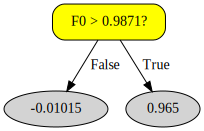

In [ ]:
def make_some_data(n):
    x = np.random.uniform(-5, 5, size=n)
    Y = (x > 1) + 0.1*np.random.normal(size=n)
    X = x.reshape(n, 1) # X needs to be a 2-dimensional matrix
    return X, Y

n = 100
X,Y = make_some_data(n)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

reg = TreeRegressor(max_depth=2, threshold=0.1)
score = cross_validate(reg, Xtrain, Ytrain, scoring='neg_mean_squared_error')
print("Cross-validation mean score:", np.mean(score['test_score']))

reg.fit(Xtrain,Ytrain)

reg.draw_tree()

By looking at the data-generating function it is reasonable to assume that we want to have a decision tree of depth one, only creating two leaf nodes. This is because we have two main clusters, where each cluster varies over similar values. If we would increase the max_depth and decrease the threshold we may overfit the data.

From the tree drawing above we can see that the result makes sense. The x-value splitting the two clusters is approximately 1. Further, the mean value for the lower cluster is close to 0 and for the upper cluster it is close to 1.

The code block below shows the accuracy on the test set, after predicting with TreeRegressor.

In [ ]:
Ypredict = reg.predict(Xtest)
print("Accuracy on test-set:", mean_squared_error(Ytest, Ypredict))

Accuracy on test-set: 0.01010194969752579


## Step 3: Predicting apartment prices using decision tree regression

In [ ]:
# Read the CSV file using Pandas.
alldata = pd.read_csv('sberbank.csv')

# Convert the timestamp string to an integer representing the year.
def get_year(timestamp):
    return int(timestamp[:4])
alldata['year'] = alldata.timestamp.apply(get_year)

# Select the 9 input columns and the output column.
selected_columns = ['price_doc', 'year', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq', 'full_all']
alldata = alldata[selected_columns]
alldata = alldata.dropna()

# Shuffle.
alldata_shuffled = alldata.sample(frac=1.0, random_state=0)

# Separate the input and output columns.
X = alldata_shuffled.drop('price_doc', axis=1)
# For the output, we'll use the log of the sales price.
Y = alldata_shuffled['price_doc'].apply(np.log)

# Split into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

# Testing which threshold to use
thresholds = [0.0001,0.001,0.01,0.1,1,10]
for threshold in thresholds:
    reg = TreeRegressor(max_depth=5, threshold=threshold)
    score = cross_validate(reg, Xtrain, Ytrain, scoring='neg_mean_squared_error')
    print(threshold, np.mean(score['test_score']))

0.0001 -0.2825632020742467
0.001 -0.2825632020742467
0.01 -0.2825632020742467
0.1 -0.28269328255271664
1 -0.38925247260237567
10 -0.38925247260237567


In above code we tested out 5 different thresholds with *max_depth = 5*. We found that *threshold <= 0.01* gave best negative mean squared error.  

Prediction accuracy: 0.2908115453881927


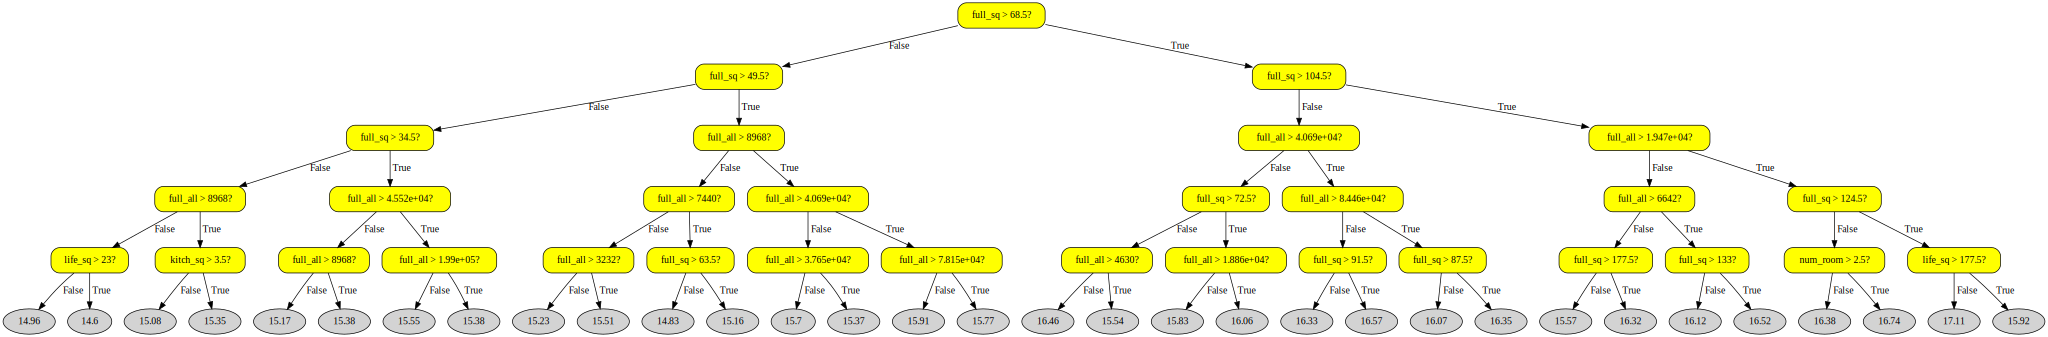

In [ ]:
reg = TreeRegressor(max_depth=5, threshold=0.01)
reg.fit(Xtrain,Ytrain)
Ypredict = reg.predict(Xtest)
print("Prediction accuracy:", mean_squared_error(Ytest, Ypredict))
reg.draw_tree()

## Step 4: Underfitting and overfitting

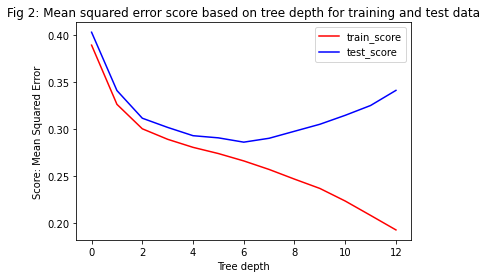

In [ ]:
train_score = []
test_score = []

max_depths = range(13)
for max_depth in max_depths:
    reg = TreeRegressor(max_depth=max_depth, threshold=0.01)
    reg.fit(Xtrain,Ytrain)
    YpredictTest = reg.predict(Xtest)
    YpredictTrain = reg.predict(Xtrain)

    train_score.append(mean_squared_error(Ytrain, YpredictTrain))
    test_score.append(mean_squared_error(Ytest, YpredictTest))

plt.plot(train_score, color = 'red', label='train_score')
plt.plot(test_score, color = 'blue', label='test_score')

plt.ylabel('Score: Mean Squared Error')
plt.xlabel('Tree depth')
plt.title('Fig 2: Mean squared error score based on tree depth for training and test data')
plt.legend()
plt.show()


What can be observed from the plot above, see Figure 2, is that the evaluation score of the training data is getting more accurate the deeper the tree is allowed to go. If too few layers, not many features or splits of values is allowed and can differ the data from one another. Many layers will consider more details of the data when determining class or in this case, value.

However, the evaluation score of the test data is getting more accurate to a certain depth, but is then getting worse if tree is allowed deeper. This is due to overfitting, where the model is fitted to details of the training data it has been fed, and will therefore not work as well for the general case and when exposed to new data. It is therefore a tradeoff of training the model to match the training data well and prevent it to be overfitted.

The evaluation score of the test data is at its best with a tree depth of six, which would in this case also be a suitible maximal depth. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=42461cb6-6f72-410b-bb93-ced1edaf8704' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>